In [23]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from sklearn.preprocessing import LabelBinarizer, Imputer
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image

# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from Translator import Translator
from preprocessor import define_blocks, extend_data
from visualization import generate_graph_tree


# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Define language and translator functions
language = "es"
translator = Translator(language)
to_lang = translator.translate_to_language
to_col = translator.translate_to_column

# Load data
raw_data = pd.read_csv("sample.txt", header=0, skiprows=1, delimiter="\t", index_col=0, usecols=list(range(0, 9)),
                       parse_dates=to_lang(["Datetime"]), decimal=",",
                       date_parser=lambda x: pd.to_datetime(x, format="%Y/%m/%d %H:%M"))
# Translate column names
raw_data.columns = (to_col(raw_data.columns))

# Divide in blocks and extend dataset
data = define_blocks(raw_data)
data = extend_data(data)
list(data.columns.values)

['Datetime',
 'Glucose_Auto',
 'Block',
 'Day_Block',
 'Overlapped_Block',
 'Carbo_Block',
 'Rapid_Insulin_Block',
 'Glucose_Mean_Block',
 'Glucose_Std_Block',
 'Glucose_Min_Block',
 'Glucose_Max_Block',
 'Glucose_Mean_Day',
 'Glucose_Std_Day',
 'Glucose_Min_Day',
 'Glucose_Max_Day',
 'MAGE',
 'Weekday',
 'Diagnosis']

## Removing columns that cannot be passed to the estimator (Datetime and day block)


In [24]:
data = data.drop(["Datetime", "Day_Block"], axis=1)

## Binarize labels in a one-vs-all fashion (Hyperglycemia, Hypoglycemia and Normal) to get binary labels

In [25]:
lb = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
lb.fit(data["Diagnosis"])
labels = pd.DataFrame(index=data.index)
for x in lb.classes_:
    labels[x + "_Diagnosis"] = np.nan 
labels.loc[:, [x + "_Diagnosis" for x in lb.classes_]] = lb.transform(data["Diagnosis"])
data = data.drop("Diagnosis", axis=1)
labels[["Hyperglycemia_Diagnosis", "Hypoglycemia_Diagnosis",
       "Normal_Diagnosis"]].iloc[[1, 200, 400, 600, 800, 1400]]

,Hyperglycemia_Diagnosis,Hypoglycemia_Diagnosis,Normal_Diagnosis
1,0,1,0
200,0,0,1
400,0,0,1
600,0,1,0
800,0,0,1
1400,1,0,0


## Infer NaN entries with mean (No MAGE)

In [26]:
data[pd.isnull(data).any(axis=1)].shape

(20, 15)

In [27]:
mp = Imputer(missing_values='NaN', strategy='mean', axis=0)
mp.fit(data)
data.loc[:, :] = mp.transform(data)

In [28]:
data[pd.isnull(data).any(axis=1)].shape

(0, 15)

# Train decision trees

In [29]:
model_hyperglycemia = DecisionTreeClassifier(criterion='entropy', splitter='best',
                              max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0,
                              max_features=None,
                              random_state=None,
                              max_leaf_nodes=None,
                              min_impurity_split=1e-07,
                              class_weight=None,
                              presort=False)
model_hypoglycemia = DecisionTreeClassifier(criterion='entropy', splitter='best',
                              max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0,
                              max_features=None,
                              random_state=None,
                              max_leaf_nodes=None,
                              min_impurity_split=1e-07,
                              class_weight=None,
                              presort=False)

In [30]:
model_hyperglycemia = model_hyperglycemia.fit(data, labels["Hyperglycemia_Diagnosis"])
model_hypoglycemia = model_hypoglycemia.fit(data, labels["Hypoglycemia_Diagnosis"])

## Visualize the decision trees

### Hyperglycemia model

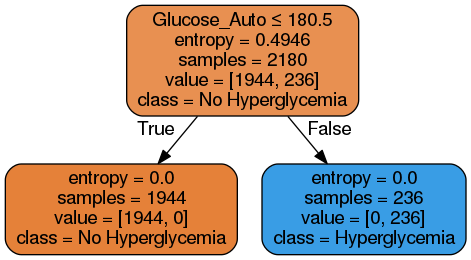

In [31]:
graph = generate_graph_tree(model_hyperglycemia, data.columns, ['No Hyperglycemia', 'Hyperglycemia'])
Image(graph.create_png())

### Hypoglycemia model


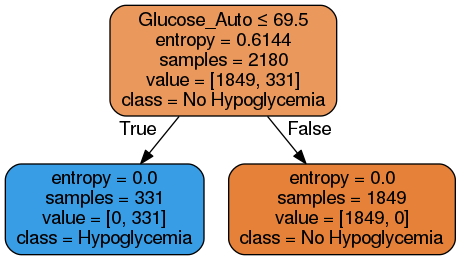

In [32]:
graph = generate_graph_tree(model_hypoglycemia, data.columns, ['No Hypoglycemia', 'Hypoglycemia'])
Image(graph.create_png())